In [4]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import albumentations as A


In [18]:
#count the number of images in the data directory
def count_images(data_dir):
    images = [f for f in os.listdir(data_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    return len(images)

data_dir_train = 'Hazmat Placards.v1i.yolov11/train/images'
data_dir_test = 'Hazmat Placards.v1i.yolov11/test/images'
data_dir_val = 'Hazmat Placards.v1i.yolov11/valid/images'
print(f'train: {count_images(data_dir_train)}')
print(f'test: {count_images(data_dir_test)}')
print(f'valid: {count_images(data_dir_val)}')


train: 1644
test: 231
valid: 491


train 7,
test 1,
valid 2,
total 10


Augmentation Train


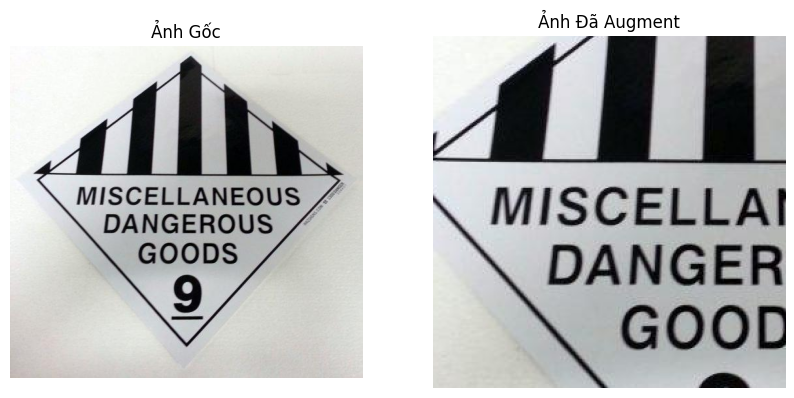

In [5]:

# Declare an augmentation pipeline
transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("Hazmat Placards.v1i.yolov11/train/images/0c93c378e8_jpg.rf.adb3ef1a8039aff9909d9bd00101e18c.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]

# Hiển thị ảnh gốc và ảnh đã augment
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Ảnh Gốc')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.title('Ảnh Đã Augment')
plt.axis('off')

plt.show()

In [27]:
with open('Hazmat Placards.v1i.yolov11/train/labels/05_jpg.rf.7a4dc84a2a01a831dd74e294d8e06bd5.txt', 'r') as f:
    lines = f.readlines()


bboxes = []
class_labels = []

# Extract bounding box values
for line in lines:
    # Lấy 5 giá trị đầu tiên (class_id, x_center, y_center, width, height)
    values = line.strip().split()[:5]  # Chỉ lấy 5 giá trị đầu tiên
    class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)
    
    # Append to bboxes and class_labels
    bboxes.append([x_center, y_center, bbox_width, bbox_height])
    class_labels.append(class_names[int(class_id)])

# Display the bounding boxes and class labels
print("BBoxes:", bboxes)
print("Class Labels:", class_labels)


BBoxes: [[0.396484375, 0.5, 0.19453125, 0.2708333333333333], [0.71640625, 0.4609375, 0.1953125, 0.26145833333333335]]
Class Labels: ['7 Radioactive', '2-2 Nonflammable gases']


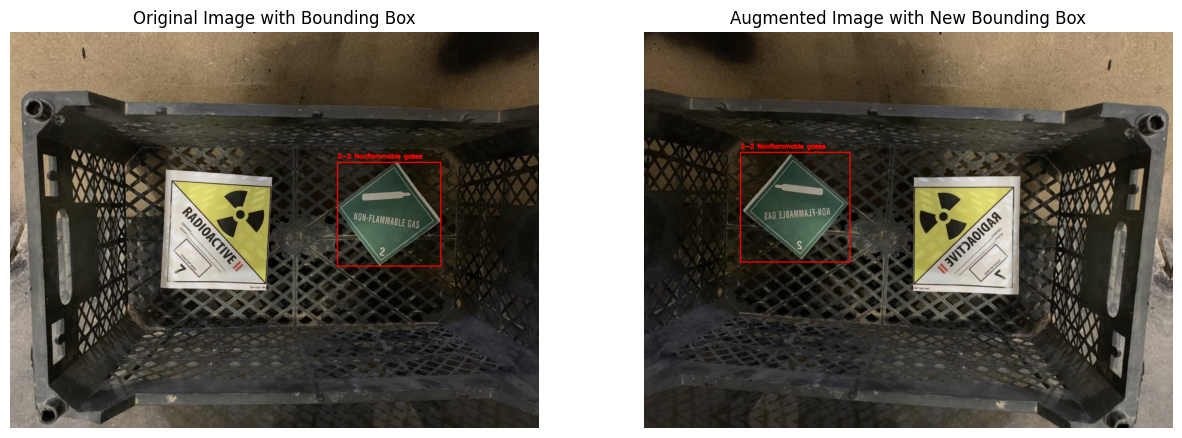

Original bounding box: [[0.71640625, 0.4609375, 0.1953125, 0.26145833333333335]]
Augmented bounding box: [[0.2857595682144165, 0.4435730278491974, 0.2068050503730774, 0.2767169177532196]]


In [26]:
class_names = [
    '1 Explosives',
    '1-1 Explosives Products with the potential to create a mass explosion',
    '1-2 Explosives Products with the potential to create a projectile hazard',
    '1-3 Explosives Products with the potential to create a fire or minor blast',
    '1-4 Explosives Products with no significant risk of creating a blast',
    '1-5 Explosives Products considered very insensitive that are used as blasting agents',
    '1-6 Explosives Products considered extremely insensitive with no risk to create a mass explosion',
    '2 Oxygen',
    '2-1 Flammable gases',
    '2-2 Nonflammable gases',
    '2-3 Toxic gases',
    '3 Combustible',
    '3 Flammable',
    '3 Flammable and combustible liquids',
    '3 Flammable liquid',
    '4-1 Flammable solids',
    '4-2 Spontaneously combustible',
    '4-3 Dangerous when wet',
    '5-1 Oxidizing substances',
    '5-2 Organic peroxides',
    '6 Poisons',
    '7 Radioactive',
    '8 Corrosive',
    '9 Miscellaneous',
    'Dangerous',
    'Environmentally Hazardous Substance',
    'Hot',
    'Infectious Substance',
    'Orange Panel',
    'Placards',
    'Spontaneously combustible material',
    'license plate'
]

# Define a custom function to clip bounding boxes
def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

# Define transformations (augmentation) with bounding box
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=40, p=0.5),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Read the original image
image = cv2.imread('Hazmat Placards.v1i.yolov11/train/images/05_jpg.rf.7a4dc84a2a01a831dd74e294d8e06bd5.jpg')
# Convert color from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

class_id = int(class_id)


# Ensure bounding box values are floats and within range (0, 1]
bboxes = [[
    float(x_center),
    float(y_center),
    float(bbox_width),
    float(bbox_height)
]]

# Update class_labels to ensure it is a list
class_labels = [class_names[class_id]]

# Apply augmentation and get new bounding boxes
augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
augmented_image = augmented['image']
augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]

# Function to draw bounding box on the image
def draw_bboxes(image, bboxes, class_labels=None):
    for i, bbox in enumerate(bboxes):
        x_center, y_center, bbox_width, bbox_height = bbox
        # Convert from YOLO to pixel coordinates
        x1 = int((x_center - bbox_width / 2) * image.shape[1])
        y1 = int((y_center - bbox_height / 2) * image.shape[0])
        x2 = int((x_center + bbox_width / 2) * image.shape[1])
        y2 = int((y_center + bbox_height / 2) * image.shape[0])
        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        if class_labels and i < len(class_labels):
            cv2.putText(image, class_labels[i], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Draw bounding box on the original image
original_image_with_bbox = image.copy()
draw_bboxes(original_image_with_bbox, bboxes, class_labels)

# Draw bounding box on the augmented image
augmented_image_with_bbox = augmented_image.copy()
draw_bboxes(augmented_image_with_bbox, augmented_bboxes, augmented['class_labels'])

# Display the original and augmented images
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_image_with_bbox)
plt.title('Original Image with Bounding Box')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_image_with_bbox)
plt.title('Augmented Image with New Bounding Box')
plt.axis('off')

plt.show()

print("Original bounding box:", bboxes)
print("Augmented bounding box:", augmented_bboxes)

In [57]:
# Class names cho các nhãn (chỉ sử dụng để map từ class_id sang tên nếu cần hiển thị, không cần thiết cho file nhãn)
class_names = [
    '1 Explosives', '1-1 Explosives Products with the potential to create a mass explosion', '1-2 Explosives Products with the potential to create a projectile hazard',
    '1-3 Explosives Products with the potential to create a fire or minor blast', '1-4 Explosives Products with no significant risk of creating a blast',
    '1-5 Explosives Products considered very insensitive that are used as blasting agents', '1-6 Explosives Products considered extremely insensitive with no risk to create a mass explosion',
    '2 Oxygen', '2-1 Flammable gases', '2-2 Nonflammable gases', '2-3 Toxic gases', '3 Combustible', '3 Flammable', '3 Flammable and combustible liquids',
    '3 Flammable liquid', '4-1 Flammable solids', '4-2 Spontaneously combustible', '4-3 Dangerous when wet', '5-1 Oxidizing substances', '5-2 Organic peroxides',
    '6 Poisons', '7 Radioactive', '8 Corrosive', '9 Miscellaneous', 'Dangerous', 'Environmentally Hazardous Substance', 'Hot', 'Infectious Substance',
    'Orange Panel', 'Placards', 'Spontaneously combustible material', 'license plate'
]

In [45]:
def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

# Define transformations (augmentation) with bounding box
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=40, p=0.5),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Read the original image
image = cv2.imread('Hazmat Placards.v1i.yolov11/train/images/05_jpg.rf.7a4dc84a2a01a831dd74e294d8e06bd5.jpg')
# Convert color from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read bounding boxes and class labels from the labels file
with open('Hazmat Placards.v1i.yolov11/train/labels/05_jpg.rf.7a4dc84a2a01a831dd74e294d8e06bd5.txt', 'r') as f:
    lines = f.readlines()

bboxes = []
class_labels = []

# Extract bounding box values
for line in lines:
    # Get the first five values (class_id, x_center, y_center, width, height)
    values = line.strip().split()[:5]  # Only take the first 5 values
    class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)
    
    # Append to bboxes and class_labels
    bboxes.append([x_center, y_center, bbox_width, bbox_height])
    class_labels.append(class_names[int(class_id)])


# Ensure bounding box values are within range (0, 1]
bboxes = [clip_bboxes(bbox) for bbox in bboxes]

# Apply augmentation and get new bounding boxes
augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
augmented_image = augmented['image']
augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]

# Function to draw bounding box on the image
def draw_bboxes(image, bboxes, class_labels=None):
    for i, bbox in enumerate(bboxes):
        x_center, y_center, bbox_width, bbox_height = bbox
        # Convert from YOLO to pixel coordinates
        x1 = int((x_center - bbox_width / 2) * image.shape[1])
        y1 = int((y_center - bbox_height / 2) * image.shape[0])
        x2 = int((x_center + bbox_width / 2) * image.shape[1])
        y2 = int((y_center + bbox_height / 2) * image.shape[0])
        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        if class_labels and i < len(class_labels):
            cv2.putText(image, class_labels[i], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Draw bounding boxes on the original image
original_image_with_bbox = image.copy()
draw_bboxes(original_image_with_bbox, bboxes, class_labels)

# Draw bounding boxes on the augmented image
augmented_image_with_bbox = augmented_image.copy()
draw_bboxes(augmented_image_with_bbox, augmented_bboxes, augmented['class_labels'])

# Display the original and augmented images
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_image_with_bbox)
plt.title('Original Image with Bounding Boxes')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_image_with_bbox)
plt.title('Augmented Image with New Bounding Boxes')
plt.axis('off')

plt.show()

print("Original bounding boxes:", bboxes)
print("Augmented bounding boxes:", augmented_bboxes)
print("Class Labels:", class_labels)


9.0


In [65]:
source_image_folder = 'datatest/train/images'
source_label_folder = 'datatest/train/labels'
destination_image_folder = 'data_aug/train/images'
destination_label_folder = 'data_aug/train/labels'

# Tạo thư mục đích nếu chưa tồn tại
os.makedirs(destination_image_folder, exist_ok=True)
os.makedirs(destination_label_folder, exist_ok=True)

# Định nghĩa hàm để clip bounding box
def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

# Định nghĩa các phép biến đổi (augmentation) với bounding box
transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomBrightnessContrast(p=1),
    A.Rotate(limit=40, p=1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Lặp qua từng file ảnh trong thư mục
for image_filename in os.listdir(source_image_folder):
    if image_filename.endswith('.jpg') or image_filename.endswith('.png'):  # Kiểm tra định dạng file ảnh
        try:
            # Đọc ảnh
            image_path = os.path.join(source_image_folder, image_filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Unable to read image {image_filename}. Skipping.")
                continue  # Bỏ qua ảnh nếu không đọc được
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển đổi từ BGR sang RGB

            # Đọc file nhãn tương ứng
            label_filename = image_filename.replace('.jpg', '.txt').replace('.png', '.txt')
            label_path = os.path.join(source_label_folder, label_filename)

            bboxes = []
            class_labels = []

            # Đọc các bounding box từ file nhãn
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                values = line.strip().split()  # Lấy tất cả các giá trị từ file nhãn
                class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)

                # Thêm vào danh sách bboxes và class_labels
                bboxes.append([x_center, y_center, bbox_width, bbox_height])
                class_labels.append(int(class_id))  # Sử dụng class_id là số nguyên

            # Đảm bảo các giá trị bounding box nằm trong khoảng (0, 1]
            bboxes = [clip_bboxes(bbox) for bbox in bboxes]

            # Áp dụng augment và lấy các bounding box mới
            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            augmented_image = augmented['image']
            augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]
            
            # Lưu ảnh gốc
            original_output_path = os.path.join(destination_image_folder, image_filename)
            cv2.imwrite(original_output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Lưu ảnh gốc

            # Lưu ảnh đã augment
            augmented_image_path = os.path.join(destination_image_folder, f'aug_{image_filename}')  # Thêm tiền tố "aug_"
            cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

            # Lưu file nhãn cho ảnh gốc
            original_label_path = os.path.join(destination_label_folder, label_filename)
            with open(original_label_path, 'w') as f:
                for bbox, class_id in zip(bboxes, class_labels):
                    f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

            # Lưu file nhãn cho ảnh đã augment
            augmented_label_path = os.path.join(destination_label_folder, f'aug_{label_filename}')  # Thêm tiền tố "aug_" cho file nhãn
            with open(augmented_label_path, 'w') as f:
                for bbox, class_id in zip(augmented_bboxes, class_labels):
                    f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

        except Exception as e:
            print(f"Error processing {image_filename}: {e}. Skipping.")

print("Augmentation completed and images and labels are saved.")


Augmentation completed and images and labels are saved.


Class ID: 9, Class Name: 2-2 Nonflammable gases
Class ID: 15, Class Name: 4-1 Flammable solids


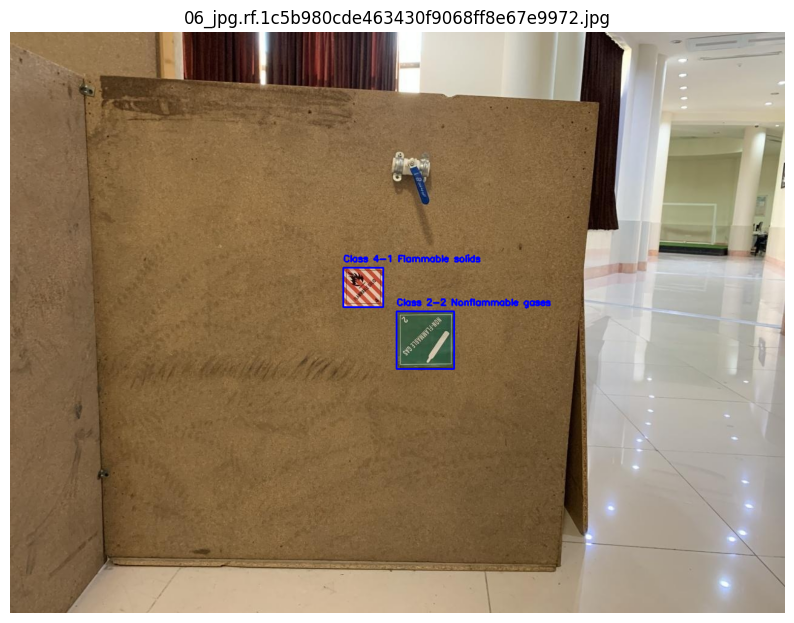

Class ID: 9, Class Name: 2-2 Nonflammable gases
Class ID: 15, Class Name: 4-1 Flammable solids


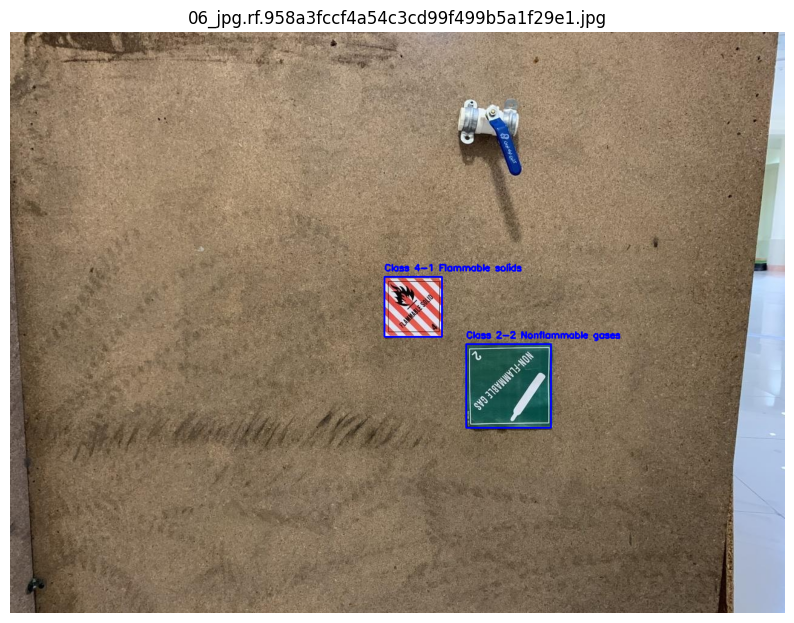

Class ID: 9, Class Name: 2-2 Nonflammable gases
Class ID: 15, Class Name: 4-1 Flammable solids


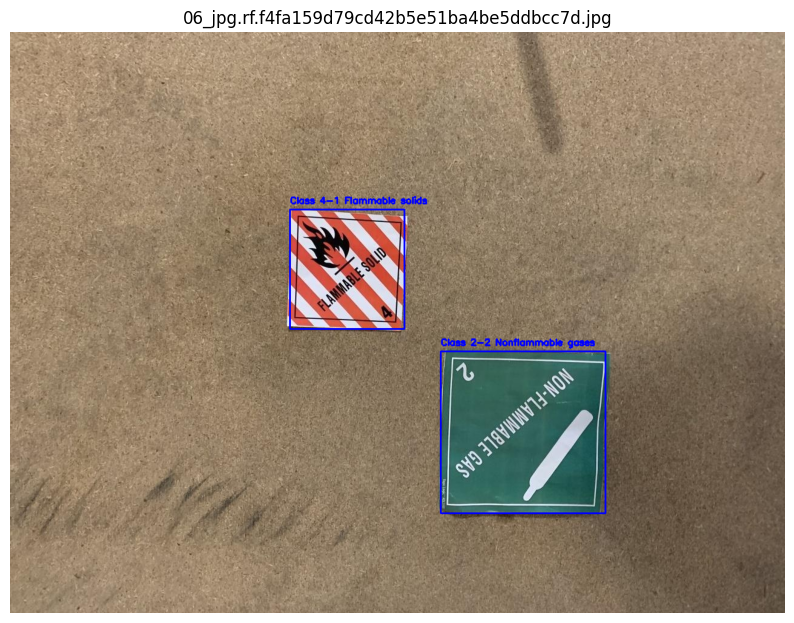

Class ID: 9, Class Name: 2-2 Nonflammable gases
Class ID: 15, Class Name: 4-1 Flammable solids


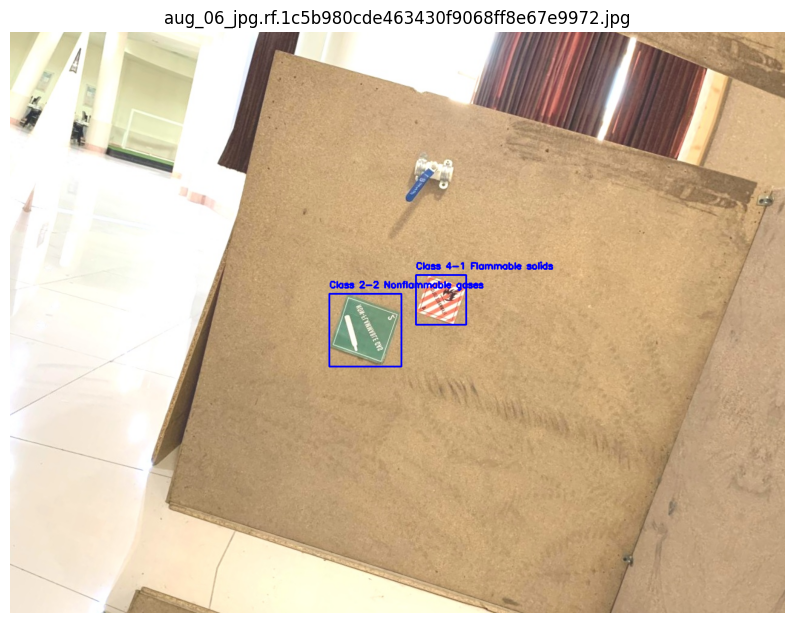

Class ID: 9, Class Name: 2-2 Nonflammable gases
Class ID: 15, Class Name: 4-1 Flammable solids


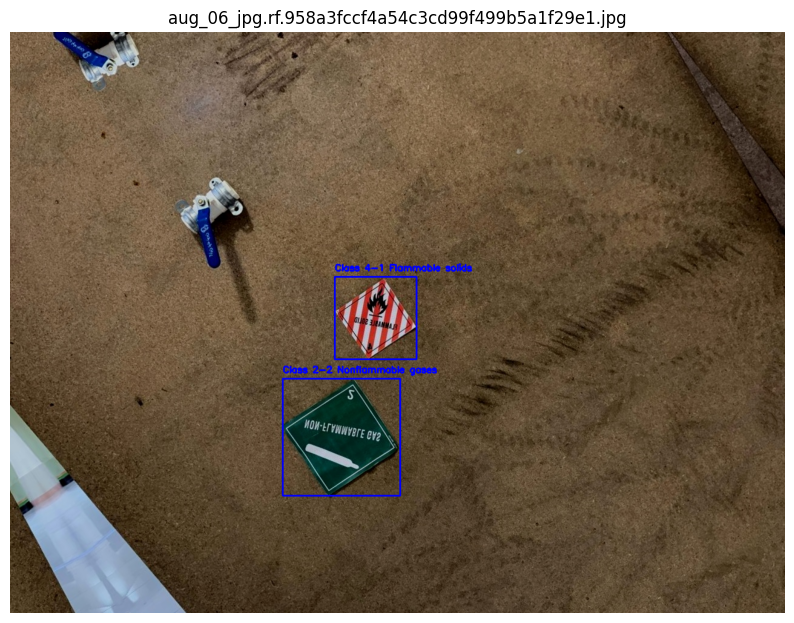

Class ID: 9, Class Name: 2-2 Nonflammable gases
Class ID: 15, Class Name: 4-1 Flammable solids


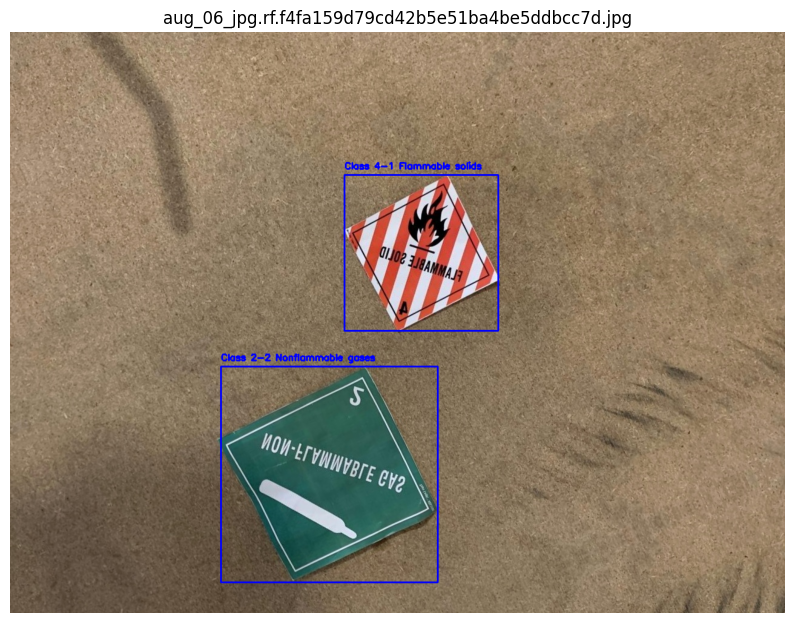

In [66]:
image_folder = 'data_aug/train/images'  # Thư mục chứa ảnh
label_folder = 'data_aug/train/labels'  # Thư mục chứa nhãn

# Lặp qua từng file ảnh trong thư mục
for image_filename in os.listdir(image_folder):
    if image_filename.endswith('.jpg') or image_filename.endswith('.png'):
        # Đọc ảnh
        image_path = os.path.join(image_folder, image_filename)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Unable to read image {image_filename}. Skipping.")
            continue  # Bỏ qua ảnh nếu không đọc được

        # Đọc file nhãn tương ứng
        label_filename = image_filename.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(label_folder, label_filename)

        # Đọc các bounding box từ file nhãn
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:  # Duyệt qua từng nhãn (nhiều nhãn cho 1 ảnh)
                values = line.strip().split()  # Lấy tất cả các giá trị trên dòng
                try:
                    # Chuyển đổi các giá trị từ chuỗi sang số
                    class_id = int(values[0])  # Lấy class_id
                    x_center, y_center, bbox_width, bbox_height = map(float, values[1:5])  # Các thông số bounding box
                    
                    # Kiểm tra và in ra class_name tương ứng với class_id
                    if class_id < len(class_names):
                        class_name = class_names[class_id]
                        print(f"Class ID: {class_id}, Class Name: {class_name}")
                    else:
                        print(f"Error: Class ID {class_id} exceeds available class names. Skipping.")
                        continue # Các thông số bounding box

                    # Tính toán tọa độ của bounding box
                    img_height, img_width, _ = image.shape
                    x1 = int((x_center - bbox_width / 2) * img_width)
                    y1 = int((y_center - bbox_height / 2) * img_height)
                    x2 = int((x_center + bbox_width / 2) * img_width)
                    y2 = int((y_center + bbox_height / 2) * img_height)

                    # Vẽ bounding box lên ảnh
                    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Màu đỏ
                    label = f"Class {class_names[class_id]}"
                    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

                except (ValueError, IndexError) as e:
                    print(f"Error processing line: {line.strip()}. Error: {e}")
                    continue

        # Convert BGR image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image using Matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.axis('off')  # Hide axis
        plt.title(image_filename)
        plt.show()
        
        


In [74]:
def add_noise_to_bboxes(image, bboxes):
    for bbox in bboxes:
        # Tính toán tọa độ của bounding box
        x1, y1, x2, y2 = bbox  # Giả sử bbox được cung cấp dưới dạng [x1, y1, x2, y2]

        # Cắt vùng bounding box
        bbox_region = image[y1:y2, x1:x2]

        # Thêm nhiễu Gaussian vào vùng bounding box
        noise = np.random.normal(0, 0.5, bbox_region.shape).astype(np.uint8)  # Điều chỉnh độ lớn của nhiễu nếu cần
        noisy_bbox_region = cv2.add(bbox_region, noise)

        # Kết hợp lại với ảnh gốc
        image[y1:y2, x1:x2] = noisy_bbox_region
    
    return image


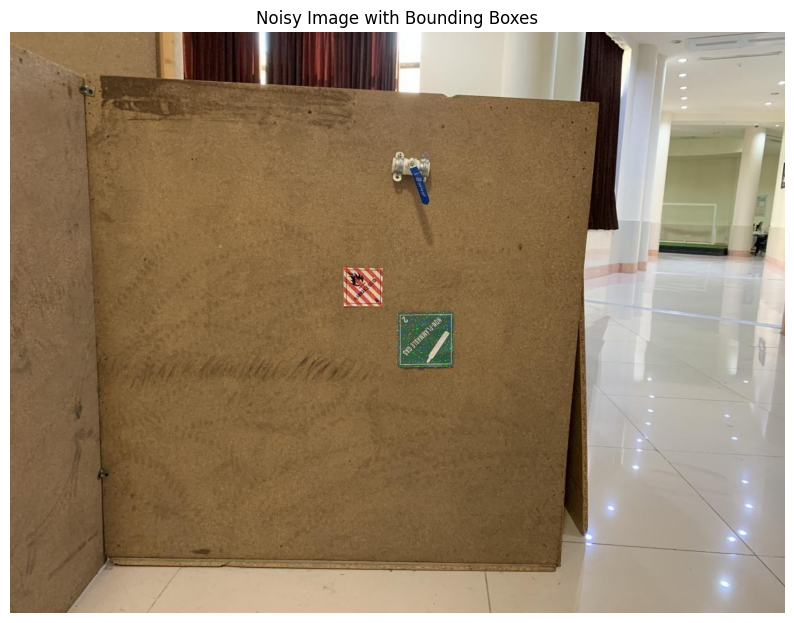

In [75]:
# Đọc ảnh
image = cv2.imread('data_aug/train/images/06_jpg.rf.1c5b980cde463430f9068ff8e67e9972.jpg')

# Danh sách các bounding box [x1, y1, x2, y2]
bboxes = [
    [0.5359375, 0.5307291666666667, 0.0734375, 0.09895833333333333],
    [0.45546875, 0.4401041666666667, 0.0515625, 0.06770833333333333],
]

# Chuyển đổi bounding box từ tỷ lệ phần trăm sang tọa độ pixel
img_height, img_width, _ = image.shape
pixel_bboxes = [
    [
        int((x_center - bbox_width / 2) * img_width),
        int((y_center - bbox_height / 2) * img_height),
        int((x_center + bbox_width / 2) * img_width),
        int((y_center + bbox_height / 2) * img_height)
    ]
    for x_center, y_center, bbox_width, bbox_height in bboxes
]

# Thêm nhiễu vào ảnh
noisy_image = add_noise_to_bboxes(image, pixel_bboxes)

# Hiển thị ảnh
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Ẩn trục
plt.title('Noisy Image with Bounding Boxes')
plt.show()
